### This notebook is to select final features using Pearson Correlation first and model-based

### Dataset already preprocessed - Missing values + Outliers + Normalised

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cat
from catboost import CatBoostRegressor, cv, Pool


from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer

# for Q-Q plots
import scipy.stats as stats

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
trainset = pd.read_csv('trainoutlier.csv')

In [3]:
trainset.shape

(1562, 40)

In [4]:
trainset.head()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876.0,408.0,24.583,397.410526,18.380,0.945945,0.010761,0.026038,0.005685,0.005635,0.0,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062000,0.310,0.166,0.100,0.083326,0.239,0.342,11.022908,5.752414,21.715153,217.0,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577.0
1,10224.0,1166.0,28.346,3.000000,26.694,0.808959,0.002284,0.173426,0.001803,0.001493,0.0,0.012033,0.000000,7.714,0.545,0.040,0.324,0.183375,0.253,0.102,0.066,0.070000,0.200,0.148,9.904099,5.752414,18.260000,181.0,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.389872,14.482893,3.158246,844.0
2,27023.0,2927.0,21.641,9.000000,31.028,0.956621,0.005141,0.013088,0.004728,0.004708,0.0,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032000,0.296,0.215,0.087,0.070000,0.187,0.258,11.011502,5.752414,19.940000,234.0,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700.0
3,8735.0,1039.0,23.110,0.000000,27.734,0.894835,0.000298,0.076576,0.000995,0.004297,0.0,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084000,0.255,0.182,0.104,0.081000,0.169,0.274,12.845770,5.752414,30.310000,231.0,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592.0
4,3681.0,365.0,21.985,2.000000,19.673,0.923886,0.000496,0.042889,0.000000,0.013622,0.0,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075000,0.324,0.118,0.113,0.083326,0.178,0.340,11.565750,5.752414,21.715153,270.0,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444.0


In [5]:
trainset.describe()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
count,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1.562000e+03,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,49114.225672,5682.920855,28.314262,218.579743,28.517017,0.770633,0.067198,0.066712,0.004483,0.008505,0.000272,0.016060,0.000754,12.025481,0.469967,0.062230,0.219656,0.087863,0.305049,0.210151,0.106540,0.082519,0.163727,0.277053,11.637336,5.752414e+00,21.413277,275.154930,3194.120384,2280.069873,0.501964,0.228032,0.166945,0.145006,0.346525,0.303117,0.200967,11.539758,10.406163,690.869398
std,52350.312542,6284.298513,7.432344,280.348295,4.401403,0.198506,0.086364,0.065213,0.004490,0.008415,0.000379,0.009269,0.000956,5.290549,0.067345,0.021321,0.066185,0.038427,0.040905,0.054311,0.022327,0.018199,0.037713,0.052664,1.524285,8.085012e-14,9.009956,56.639382,1639.713168,1109.723035,0.014393,0.031623,0.041844,0.065225,0.070378,0.051584,0.079608,2.451829,2.727474,161.102958
min,269.000000,64.000000,8.672750,-1.000000,17.711625,0.224700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000,0.012000,0.053000,0.018000,0.211000,0.075000,0.047375,0.038500,0.087000,0.139500,7.209413,5.752414e+00,3.140000,116.000000,340.000000,279.000000,0.471000,0.151000,0.063500,0.019000,0.156669,0.167145,0.064128,5.626693,3.158246,351.000000
25%,10452.750000,1078.250000,22.874000,6.000000,25.869000,0.649967,0.005523,0.018747,0.001201,0.002391,0.000000,0.009465,0.000000,7.991000,0.425000,0.046000,0.172000,0.059000,0.283000,0.174000,0.092000,0.070000,0.144000,0.243000,10.443252,5.752414e+00,14.935000,233.000000,1919.250000,1429.000000,0.495000,0.208000,0.140000,0.094226,0.300601,0.269461,0.142142,10.014818,8.613691,578.000000
50%,25282.000000,2754.000000,27.199500,72.500000,28.768000,0.846542,0.020599,0.037613,0.002610,0.005279,0.000000,0.014438,0.000302,11.173500,0.470500,0.061000,0.216000,0.079000,0.306000,0.211682,0.105000,0.080000,0.164818,0.281000,11.884105,5.752414e+00,21.715153,270.000000,2889.500000,2080.000000,0.504000,0.227000,0.164500,0.129388,0.352176,0.303303,0.182365,11.435441,10.396898,650.000000
75%,68361.500000,7987.000000,32.341500,397.410526,31.307250,0.933479,0.102047,0.092998,0.006121,0.011886,0.000403,0.020999,0.001197,15.018500,0.515000,0.076000,0.265000,0.108750,0.331000,0.240000,0.121750,0.091000,0.182000,0.312000,12.879822,5.752414e+00,26.015000,311.000000,3937.250000,2747.500000,0.511000,0.246000,0.191000,0.187719,0.396556,0.337672,0.241234,12.940235,12.250655,773.750000
max,155224.625000,18350.125000,46.542750,984.526316,39.464625,0.995141,0.246833,0.204374,0.013501,0.026130,0.001007,0.038300,0.002992,25.559750,0.650000,0.121000,0.404500,0.183375,0.403000,0.339000,0.166375,0.122500,0.239000,0.415500,14.992477,5.752414e+00,42.635000,428.000000,6964.250000,4725.250000,0.535000,0.303000,0.267500,0.327959,0.535536,0.439989,0.389872,17.3283

In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 40 columns):
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1562 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other                                     1562 non-null float64
poverty_r

### Drop Multicollinearity features

In [7]:
trainset1 = trainset.drop(labels=['renter_occupied_households','evictions'],axis=1)

In [8]:
trainset1.head()

,population,pct_renter_occupied,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876.0,24.583,18.380,0.945945,0.010761,0.026038,0.005685,0.005635,0.0,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062000,0.310,0.166,0.100,0.083326,0.239,0.342,11.022908,5.752414,21.715153,217.0,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577.0
1,10224.0,28.346,26.694,0.808959,0.002284,0.173426,0.001803,0.001493,0.0,0.012033,0.000000,7.714,0.545,0.040,0.324,0.183375,0.253,0.102,0.066,0.070000,0.200,0.148,9.904099,5.752414,18.260000,181.0,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.389872,14.482893,3.158246,844.0
2,27023.0,21.641,31.028,0.956621,0.005141,0.013088,0.004728,0.004708,0.0,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032000,0.296,0.215,0.087,0.070000,0.187,0.258,11.011502,5.752414,19.940000,234.0,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700.0
3,8735.0,23.110,27.734,0.894835,0.000298,0.076576,0.000995,0.004297,0.0,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084000,0.255,0.182,0.104,0.081000,0.169,0.274,12.845770,5.752414,30.310000,231.0,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592.0
4,3681.0,21.985,19.673,0.923886,0.000496,0.042889,0.000000,0.013622,0.0,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075000,0.324,0.118,0.113,0.083326,0.178,0.340,11.565750,5.752414,21.715153,270.0,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444.0


In [9]:
trainset1.shape

(1562, 38)

### Check features correlation with gross_rent (less than 0.8)

In [10]:
pearson = trainset1

In [11]:
pearson

,population,pct_renter_occupied,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876.000,24.583,18.380000,0.945945,0.010761,0.026038,0.005685,0.005635,0.000000,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062000,0.310,0.166000,0.100,0.083326,0.239000,0.342,11.022908,5.752414,21.715153,217.0,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577.0
1,10224.000,28.346,26.694000,0.808959,0.002284,0.173426,0.001803,0.001493,0.000000,0.012033,0.000000,7.714,0.545,0.040,0.324,0.183375,0.253,0.102000,0.066,0.070000,0.200000,0.148,9.904099,5.752414,18.260000,181.0,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.389872,14.482893,3.158246,844.0
2,27023.000,21.641,31.028000,0.956621,0.005141,0.013088,0.004728,0.004708,0.000000,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032000,0.296,0.215000,0.087,0.070000,0.187000,0.258,11.011502,5.752414,19.940000,234.0,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700.0
3,8735.000,23.110,27.734000,0.894835,0.000298,0.076576,0.000995,0.004297,0.000000,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084000,0.255,0.182000,0.104,0.081000,0.169000,0.274,12.845770,5.752414,30.310000,231.0,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592.0
4,3681.000,21.985,19.673000,0.923886,0.000496,0.042889,0.000000,0.013622,0.000000,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075000,0.324,0.118000,0.113,0.083326,0.178000,0.340,11.565750,5.752414,21.715153,270.0,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,18983.000,22.621,26.905000,0.847652,0.064786,0.048670,0.000000,0.012277,0.001007,0.024815,0.000000,5.699,0.517,0.044,0.216,0.086000,0.302,0.211682,0.096,0.079000,0.164818,0.227,12.942281,5.752414,28.940000,207.0,6299.000000,4660.000000,0.510,0.243,0.144,0.153614,0.347390,0.263052,0.235944,11.369618,7.211285,928.0
1558,18837.000,28.649,26.515000,0.925500,0.010666,0.028790,0.000398,0.020893,0.001007,0.012667,0.000000,6.789,0.559,0.043,0.112,0.038000,0.294,0.169000,0.081,0.060000,0.166000,0.242,10.669456,5.752414,18.020000,272.0,2030.000000,1249.000000,0.510,0.205,0.193,0.070858,0.371257,0.311377,0.246507,9.330009,12.600874,640.0
1559,77224.000,18.928,28.827000,0.883936,0.070858,0.019081,0.000614,0.012569,0.000302,0.011835,0.000805,6.294,0.498,0.051,0.172,0.071000,0.260,0.193000,0.096,0.080000,0.168000,0.298,12.962100,5.752414,13.780000,237.0,6964.250000,1529.000000,0.503,0.211,0.179,0.118644,0.311067,0.302094,0.268195,9.029286,8.846613,754.0
1560,4698.000,20.107,39.464625,0.224700,0.000911,0.204374,0.000401,0.000000,0.000000,0.000000,0.000200,17.300,0.493,0.112,0.273,0.129000,0.235,0.171000,0.099,0.110000,0.131000,0.246,10.244994,5.752414,21.715153,192.0,4710.000000,2508.303867,0.484,0.195,0.206,0.164000,0.354000,0.342000,0.140000,8.445214,9.744478,640.0


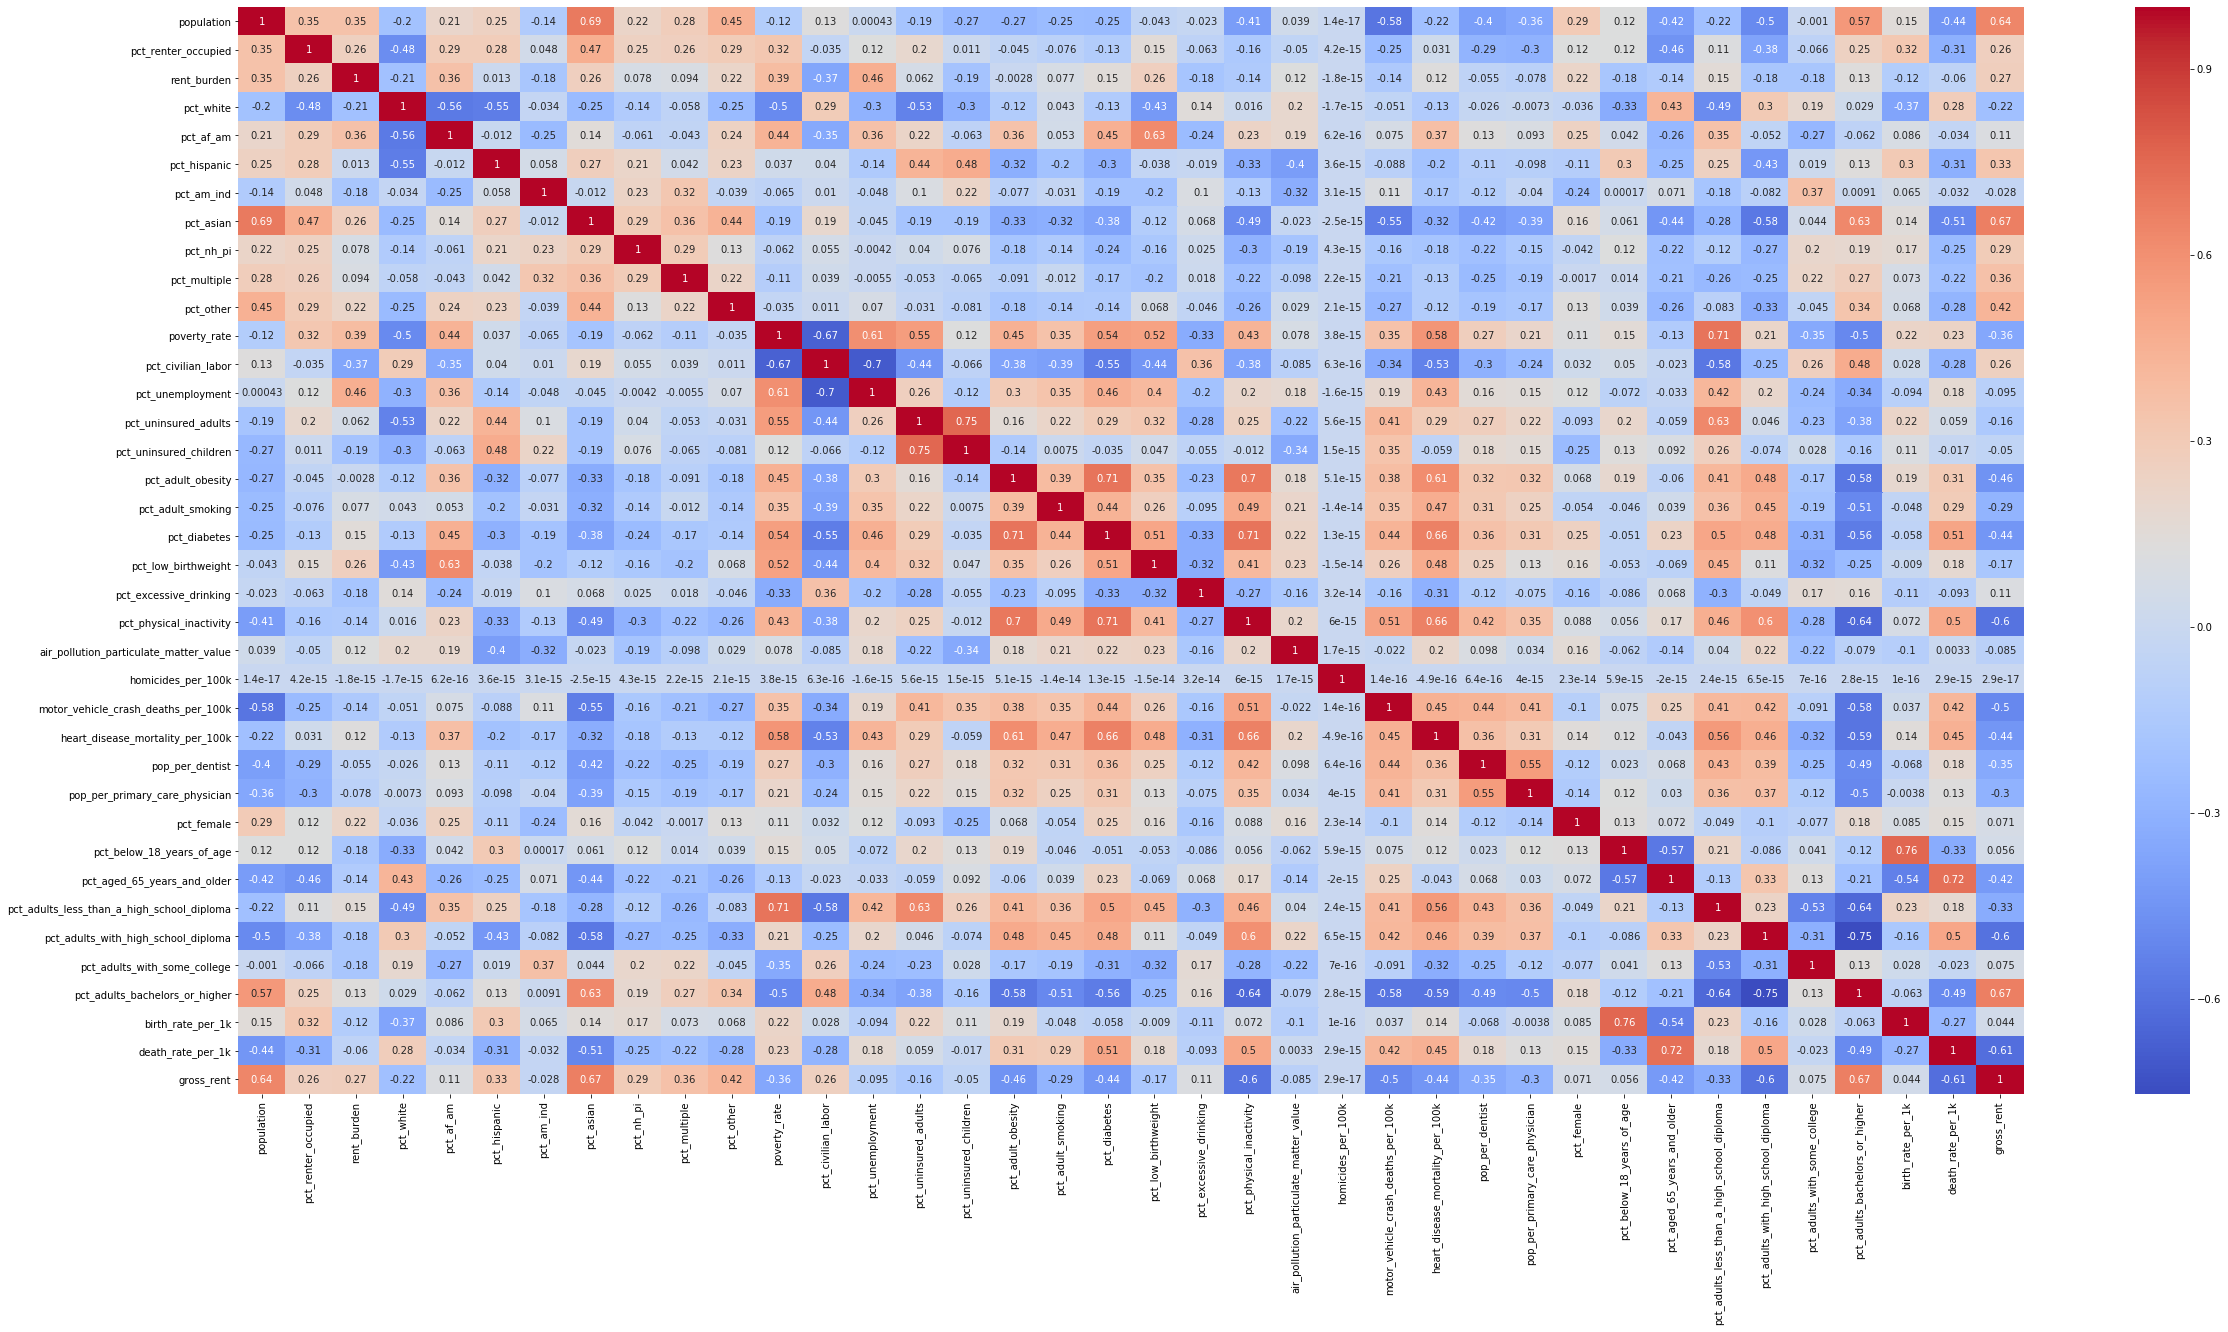

In [12]:
plt.figure(figsize=(40,20))
sns.heatmap(pearson.corr(method='pearson'),annot=True,cmap="coolwarm")
plt.show()

In [13]:
#pearson.to_csv("pearsonselect.csv",index=False)

In [14]:
X_num = pearson.iloc[:,0:37]
y_num = pearson.iloc[:,37]

In [15]:
X_num.shape

(1562, 37)

In [16]:
y_num.shape

(1562,)

In [17]:
X_num.values

array([[3.87600000e+03, 2.45830000e+01, 1.83800000e+01, ...,
        1.99598796e-01, 1.00089824e+01, 9.75234185e+00],
       [1.02240000e+04, 2.83460000e+01, 2.66940000e+01, ...,
        3.89871642e-01, 1.44828927e+01, 3.15824596e+00],
       [2.70230000e+04, 2.16410000e+01, 3.10280000e+01, ...,
        2.19560878e-01, 9.62034648e+00, 1.08735717e+01],
       ...,
       [7.72240000e+04, 1.89280000e+01, 2.88270000e+01, ...,
        2.68195414e-01, 9.02928647e+00, 8.84661304e+00],
       [4.69800000e+03, 2.01070000e+01, 3.94646250e+01, ...,
        1.40000000e-01, 8.44521438e+00, 9.74447813e+00],
       [1.55224625e+05, 3.77890000e+01, 3.06870000e+01, ...,
        3.59281437e-01, 1.39446283e+01, 6.17315807e+00]])

In [18]:
y_num.values

array([577., 844., 700., ..., 754., 640., 976.])

### Tree Based Method Feature Selection

In [19]:
rf = RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1)

In [20]:
rfFit = rf.fit(X_num,y_num)

In [21]:
print(rfFit.feature_importances_)

[0.16889377 0.01547666 0.02204843 0.0208348  0.01236404 0.02454015
 0.0124182  0.07800017 0.0062792  0.02060468 0.02171141 0.03824156
 0.01376098 0.0166552  0.01066811 0.01618632 0.04347319 0.0143321
 0.01211445 0.00720039 0.01094981 0.0258727  0.01703286 0.
 0.01111836 0.014609   0.01375174 0.0112097  0.01124022 0.01299466
 0.03033275 0.01659812 0.0324182  0.01685118 0.11166106 0.01559628
 0.07195957]


In [22]:
colname = pd.DataFrame(trainset1.columns, columns=['Name'])

In [23]:
colname.head()

,Name
0,population
1,pct_renter_occupied
2,rent_burden
3,pct_white
4,pct_af_am


In [24]:
result = pd.DataFrame(rfFit.feature_importances_,columns=['result'])

In [25]:
result.head()

,result
0,0.168894
1,0.015477
2,0.022048
3,0.020835
4,0.012364


In [26]:
combined = pd.concat([colname,result],axis=1)

In [27]:
combined.sort_values(by='result')

,Name,result
23,homicides_per_100k,0.000000
8,pct_nh_pi,0.006279
19,pct_low_birthweight,0.007200
14,pct_uninsured_adults,0.010668
20,pct_excessive_drinking,0.010950
24,motor_vehicle_crash_deaths_per_100k,0.011118
27,pop_per_primary_care_physician,0.011210
28,pct_female,0.011240
18,pct_diabetes,0.012114
4,pct_af_am,0.012364


**Significant feature = 'population', 'pct_adults_bachelors_or_higher','pct_asian','death_rate_per_1k', 
poverty_rate, pct_adult_obesity, pct_aged_65_years_and_older **

In [28]:
et = ExtraTreesRegressor(n_estimators=100,criterion='mae',n_jobs=-1)
etFit = et.fit(X_num,y_num)

In [29]:
etFit.feature_importances_

array([0.17355656, 0.0178934 , 0.02015034, 0.01725197, 0.0157606 ,
       0.02568795, 0.01414281, 0.07227396, 0.01265769, 0.02238201,
       0.02502395, 0.03486707, 0.0159289 , 0.0180455 , 0.01253196,
       0.0162287 , 0.03403964, 0.01662545, 0.01451961, 0.01112251,
       0.01357348, 0.02781202, 0.01633019, 0.        , 0.01250463,
       0.0192549 , 0.01489702, 0.01270207, 0.01397584, 0.01490629,
       0.02821817, 0.01527613, 0.02994434, 0.01671939, 0.10077841,
       0.0158357 , 0.05658083])

In [30]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [31]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [32]:
result = pd.DataFrame(etFit.feature_importances_,columns=['Result'])

In [33]:
result.head()

,Result
0,0.173557
1,0.017893
2,0.020150
3,0.017252
4,0.015761


In [34]:
combined = pd.concat([colname,result],axis=1)

In [35]:
combined.sort_values(by='Result')

,Name,Result
23,pct_physical_inactivity,0.000000
19,pct_adult_smoking,0.011123
24,air_pollution_particulate_matter_value,0.012505
14,pct_civilian_labor,0.012532
8,pct_am_ind,0.012658
27,heart_disease_mortality_per_100k,0.012702
20,pct_diabetes,0.013573
28,pop_per_dentist,0.013976
6,pct_af_am,0.014143
18,pct_adult_obesity,0.014520


**Significant Features = pct_adults_bachelors_or_higher, pct_asian, population, death_rate_per_1k,
renter_occupied_households, pct_adults_with_high_school_diploma, poverty_rate **

### Using LightGBM

In [36]:
trainingdata = lgb.Dataset(data=X_num, label=y_num)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = ['mean_absolute_error']

lgbmodel = lgb.train(params=params,train_set=trainingdata,num_boost_round=100)

In [37]:
lgbmodel.feature_importance()

array([159,  81, 142, 112,  78,  95,  72,  66,  32, 100,  54, 169,  94,
        85,  56,  89,  95,  83,  85,  25,  48,  77,  99,   0,  47,  64,
        56,  60,  53,  69,  93,  84,  73,  82, 100,  90, 133])

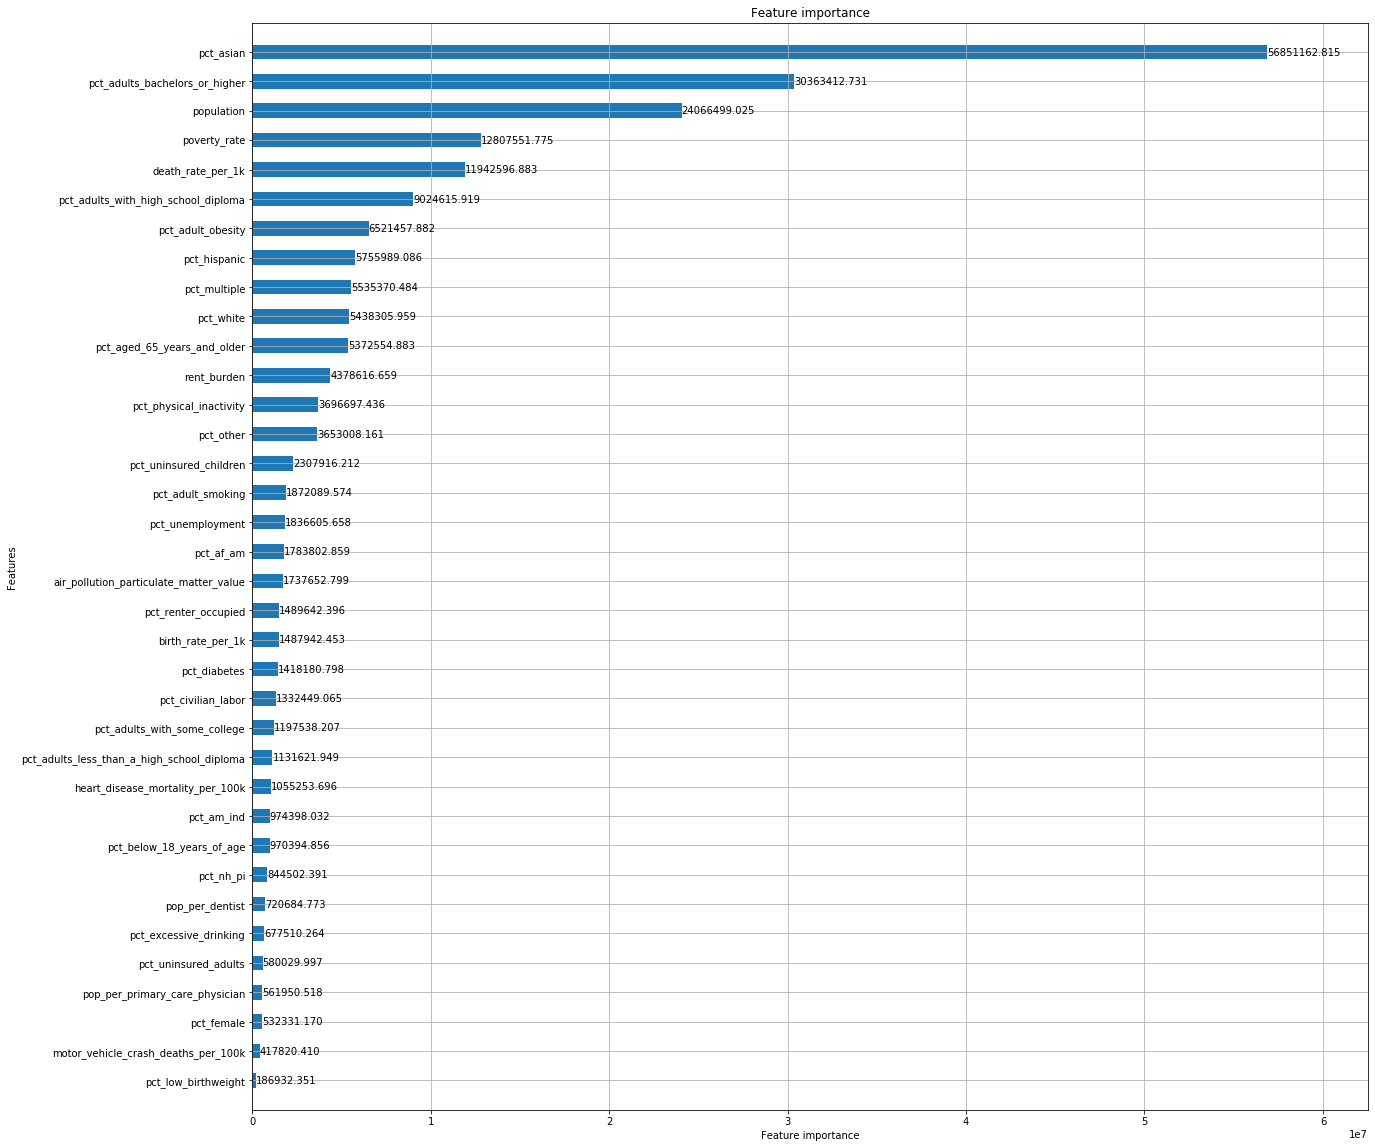

In [38]:
lgb.plot_importance(lgbmodel,height=0.5, figsize=(20,20), importance_type='gain')
plt.show()

In [39]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [40]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [41]:
result = pd.DataFrame(lgbmodel.feature_importance(),columns=['Result'])

In [42]:
result.head()

,Result
0,159
1,81
2,142
3,112
4,78


In [43]:
combined = pd.concat([colname,result], axis=1)

In [44]:
combined.sort_values(by='Result')

,Name,Result
23,pct_physical_inactivity,0.0
19,pct_adult_smoking,25.0
8,pct_am_ind,32.0
24,air_pollution_particulate_matter_value,47.0
20,pct_diabetes,48.0
28,pop_per_dentist,53.0
10,pct_nh_pi,54.0
26,motor_vehicle_crash_deaths_per_100k,56.0
14,pct_civilian_labor,56.0
27,heart_disease_mortality_per_100k,60.0


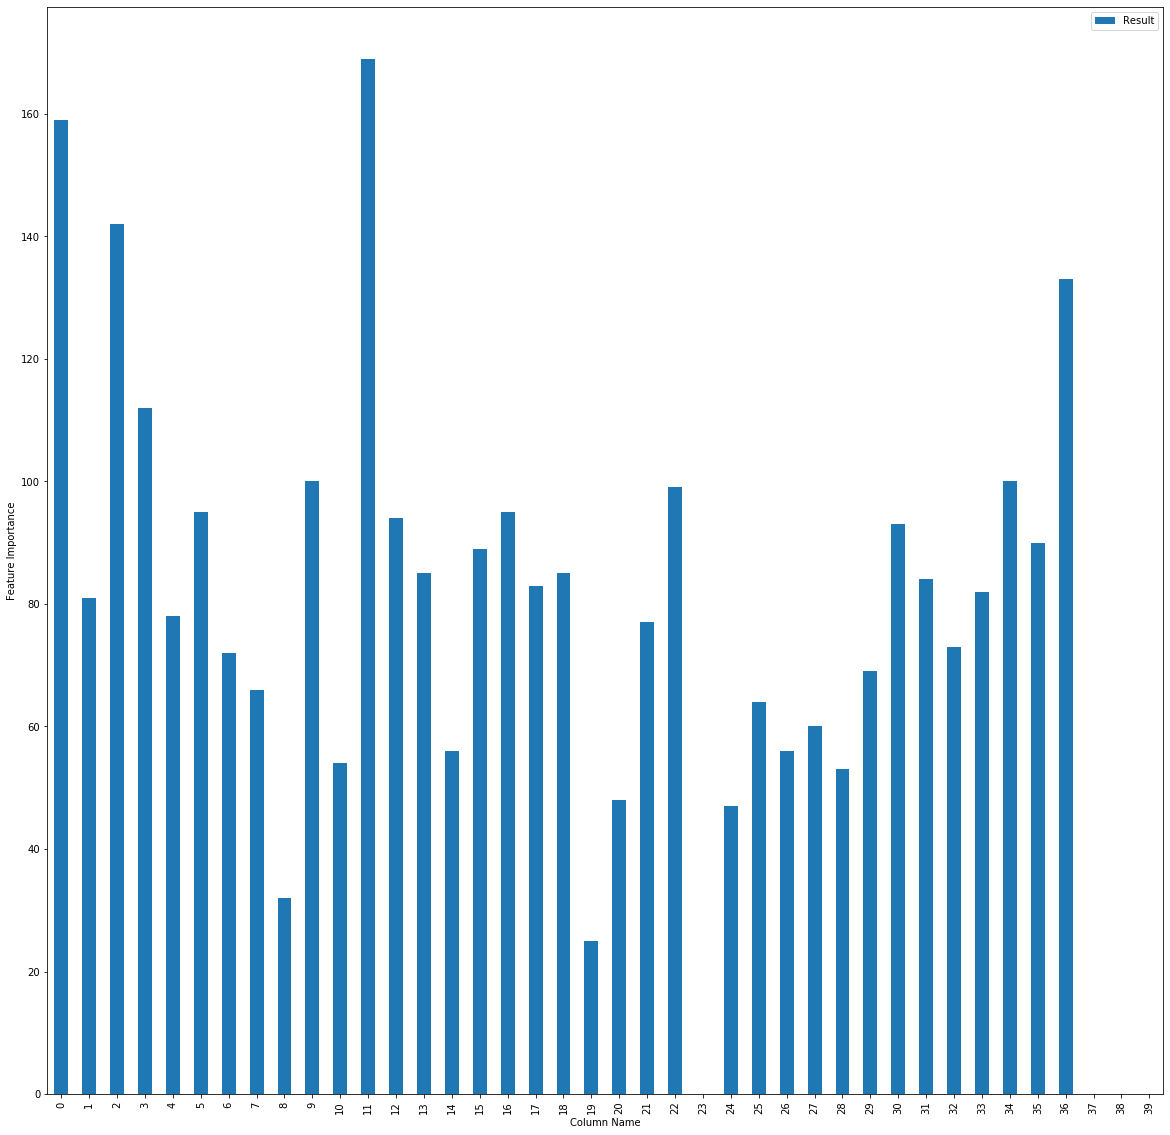

In [45]:
combined.plot(kind='bar',figsize=(20,20))
plt.xlabel("Column Name")
plt.ylabel("Feature Importance")
plt.show()

**Significant features = pct_adults_bachelors_or_higher, pct_asian, poverty_rate, population,
pct_adult_obesity,death_rate_per_1k, pct_white **

### Using XGBoost

In [46]:
xgbreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgbreg.fit(X_num,y_num)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [47]:
print(xgbreg.feature_importances_)

[0.05675014 0.00388411 0.00952985 0.01924074 0.00741199 0.03386347
 0.00587156 0.2594409  0.02128258 0.02150408 0.04209768 0.01928147
 0.00434509 0.01542467 0.00618018 0.00642542 0.02942679 0.00509123
 0.00696612 0.0073616  0.00324373 0.03518904 0.00658299 0.
 0.00885756 0.00305543 0.00576598 0.00285264 0.00548353 0.00248542
 0.02335122 0.00569604 0.10460823 0.00512991 0.13482206 0.00573744
 0.0657591 ]


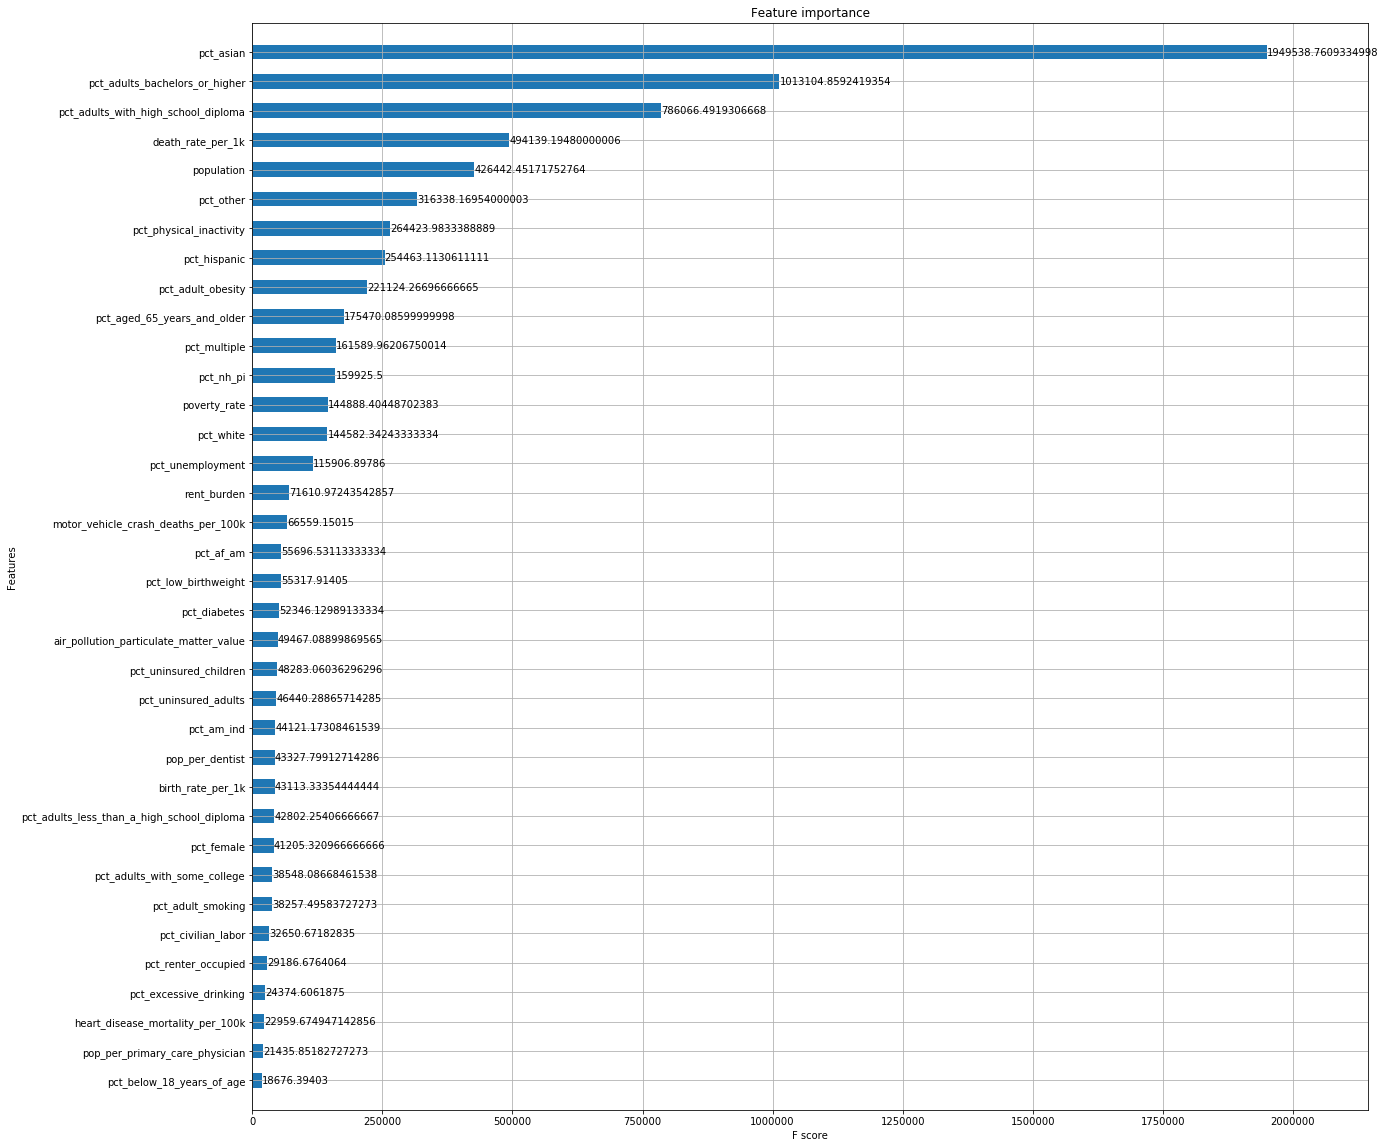

In [48]:
ax = xgb.plot_importance(xgbreg,height=0.5,importance_type='gain')
fig = ax.figure
fig.set_size_inches(20,20)

In [49]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [50]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [51]:
result = pd.DataFrame(xgbreg.feature_importances_, columns=['Result'])

In [52]:
result.head()

,Result
0,0.056750
1,0.003884
2,0.009530
3,0.019241
4,0.007412


In [53]:
combined = pd.concat([colname,result], axis=1)

In [54]:
combined.sort_values(by='Result')

,Name,Result
23,pct_physical_inactivity,0.000000
29,pop_per_primary_care_physician,0.002485
27,heart_disease_mortality_per_100k,0.002853
25,homicides_per_100k,0.003055
20,pct_diabetes,0.003244
1,renter_occupied_households,0.003884
12,pct_other,0.004345
17,pct_uninsured_children,0.005091
33,pct_adults_less_than_a_high_school_diploma,0.005130
28,pop_per_dentist,0.005484


**Significant Features: pct_adults_bachelors_or_higher, pct_asian, pct_adults_with_high_school_diploma, 
population, pct_adult_obesity, death_rate_per_1k, pct_physical_inactivity  **

### Using Catboost

In [55]:
#Define a Pool Dataset
trainpool = Pool(data=X_num,label=y_num)

In [56]:
catreg = cat.CatBoostRegressor(iterations=100,loss_function='MAE')
catreg.fit(X_num,y_num)

0:	learn: 121.8570014	total: 71.5ms	remaining: 7.07s
1:	learn: 119.6519790	total: 78.5ms	remaining: 3.85s
2:	learn: 117.4159243	total: 89.3ms	remaining: 2.89s
3:	learn: 115.4660976	total: 96.9ms	remaining: 2.33s
4:	learn: 113.5420909	total: 104ms	remaining: 1.98s
5:	learn: 111.6830307	total: 111ms	remaining: 1.74s
6:	learn: 109.8058672	total: 118ms	remaining: 1.57s
7:	learn: 107.9778078	total: 125ms	remaining: 1.44s
8:	learn: 106.2648813	total: 132ms	remaining: 1.33s
9:	learn: 104.7805997	total: 139ms	remaining: 1.25s
10:	learn: 103.0698107	total: 150ms	remaining: 1.21s
11:	learn: 101.5084806	total: 157ms	remaining: 1.15s
12:	learn: 99.9257622	total: 164ms	remaining: 1.1s
13:	learn: 98.7893500	total: 171ms	remaining: 1.05s
14:	learn: 97.5314095	total: 178ms	remaining: 1.01s
15:	learn: 96.2400388	total: 185ms	remaining: 972ms
16:	learn: 94.8731297	total: 192ms	remaining: 938ms
17:	learn: 93.6104603	total: 199ms	remaining: 907ms
18:	learn: 92.3760452	total: 210ms	remaining: 896ms
19:	lea

In [57]:
catreg.get_feature_importance(type='PredictionValuesChange')

array([15.30256218,  0.90995883,  1.36964483,  3.87236076,  1.42882416,
        4.34910739,  0.42878832,  6.35385296,  0.25858572,  1.91132624,
        2.65574109,  7.23666389,  1.62489688,  1.57635227,  0.57274817,
        2.51004742,  3.12214984,  0.53131364,  1.16299332,  0.96335186,
        0.88537062,  5.41108215,  1.32462515,  0.        ,  1.16954888,
        0.79537003,  0.72025959,  0.61770274,  0.44541735,  0.34036292,
        2.49048102,  1.04405802,  4.93004406,  0.75144708,  9.29601996,
        1.0379589 , 10.59898176])

In [58]:
colname = pd.DataFrame(pearson.columns, columns=['Name'])

In [59]:
colname.head()

,Name
0,population
1,pct_renter_occupied
2,rent_burden
3,pct_white
4,pct_af_am


In [60]:
result = pd.DataFrame(catreg.feature_importances_, columns=['Result'])

In [61]:
result.head()

,Result
0,15.302562
1,0.909959
2,1.369645
3,3.872361
4,1.428824


In [62]:
combined = pd.concat([colname,result], axis=1)

In [63]:
combined.sort_values(by='Result')

,Name,Result
23,homicides_per_100k,0.000000
8,pct_nh_pi,0.258586
29,pct_below_18_years_of_age,0.340363
6,pct_am_ind,0.428788
28,pct_female,0.445417
17,pct_adult_smoking,0.531314
14,pct_uninsured_adults,0.572748
27,pop_per_primary_care_physician,0.617703
26,pop_per_dentist,0.720260
33,pct_adults_with_some_college,0.751447


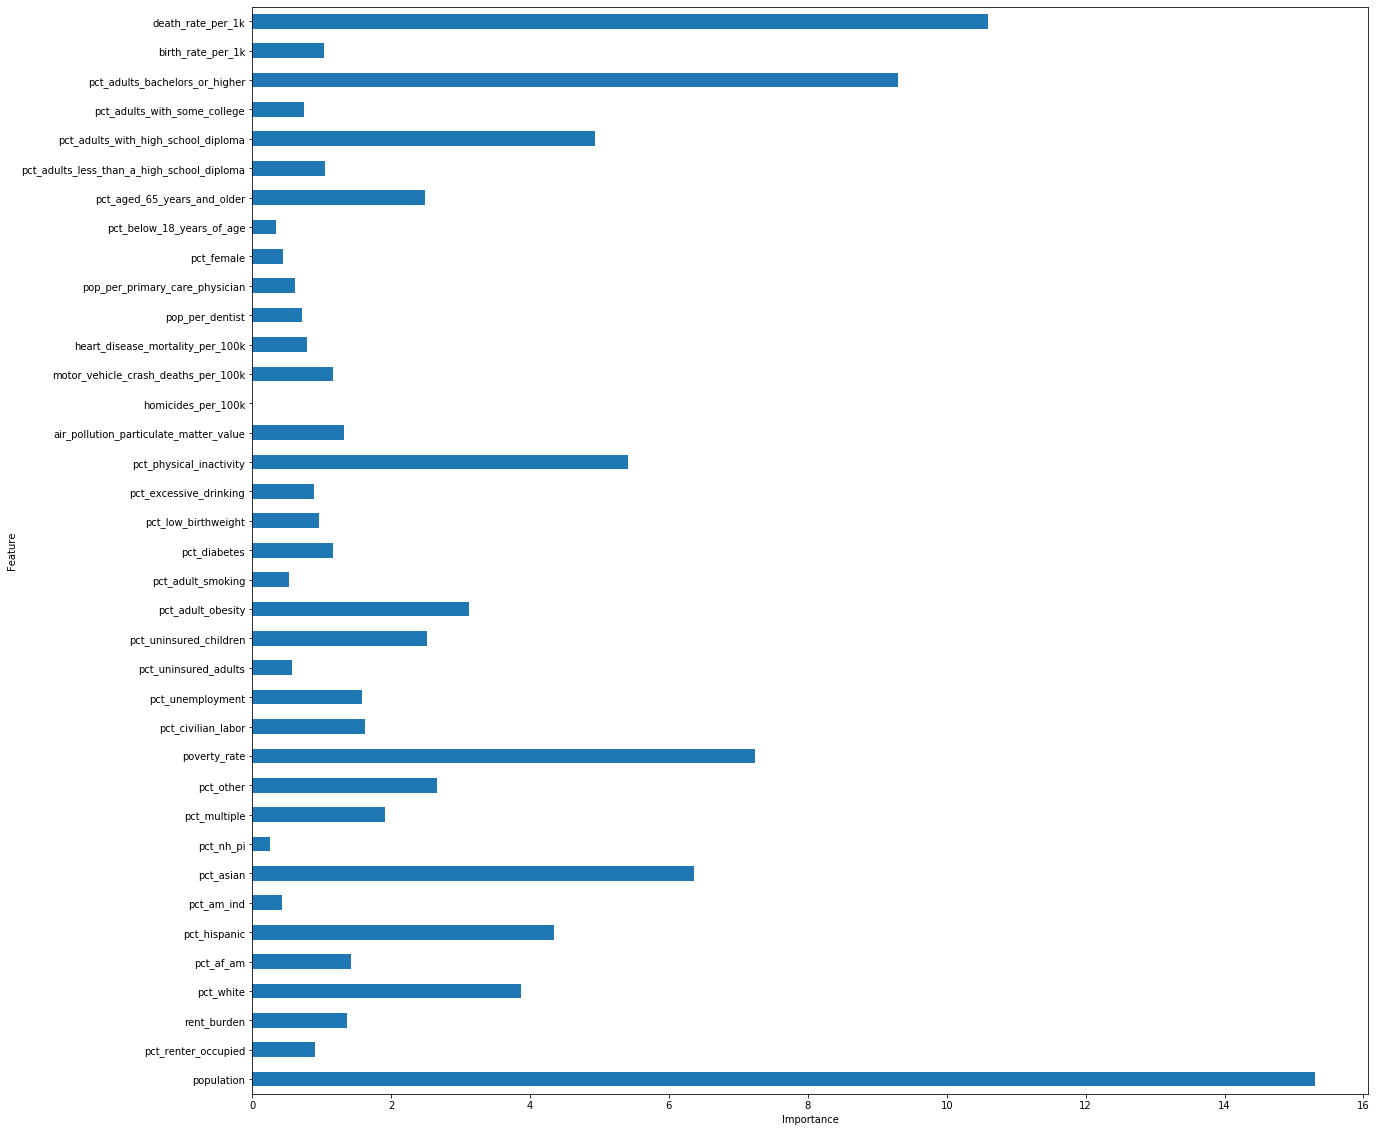

In [64]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.feature_importances_,index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

**Significant features: pct_adults_bachelors_or_higher,death_rate_per_1k, population, poverty rate, pct_adults_with_high_school_diploma, pct_physical_inactivity, renter_occupied_households, pct_asian **

In [65]:
catreg.get_feature_importance(data=trainpool,type='LossFunctionChange')

array([9.02316151, 0.18228773, 0.71513331, 2.07934306, 0.65421373,
       2.50326319, 0.18684077, 2.77149971, 0.11082661, 0.90946215,
       1.17049413, 4.80191649, 0.59208666, 0.78723471, 0.12747851,
       0.7622469 , 1.09500808, 0.20546545, 0.30327581, 0.24841711,
       0.30648951, 2.893278  , 0.41114621, 0.        , 0.43180545,
       0.51101324, 0.35395358, 0.18164739, 0.13055819, 0.07621059,
       0.93777533, 0.5374903 , 2.04325864, 0.211542  , 4.12648027,
       0.23435579, 6.61477249])

In [66]:
result2 = pd.DataFrame(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), columns=['LossFunction'])

In [67]:
result2

,LossFunction
0,9.023162
1,0.182288
2,0.715133
3,2.079343
4,0.654214
5,2.503263
6,0.186841
7,2.771500
8,0.110827
9,0.909462


In [68]:
combined2 = pd.concat([colname,result2], axis=1)

In [69]:
combined3 = combined2.sort_values(by='LossFunction')

In [70]:
combined3

,Name,LossFunction
23,homicides_per_100k,0.000000
29,pct_below_18_years_of_age,0.076211
8,pct_nh_pi,0.110827
14,pct_uninsured_adults,0.127479
28,pct_female,0.130558
27,pop_per_primary_care_physician,0.181647
1,pct_renter_occupied,0.182288
6,pct_am_ind,0.186841
17,pct_adult_smoking,0.205465
33,pct_adults_with_some_college,0.211542


**Significant features: death_rate_per_1k, poverty rate, population, pct_adults_bachelors_or_higher, 
pct_asian, pct_hispanic, pct_physical_inactivity **

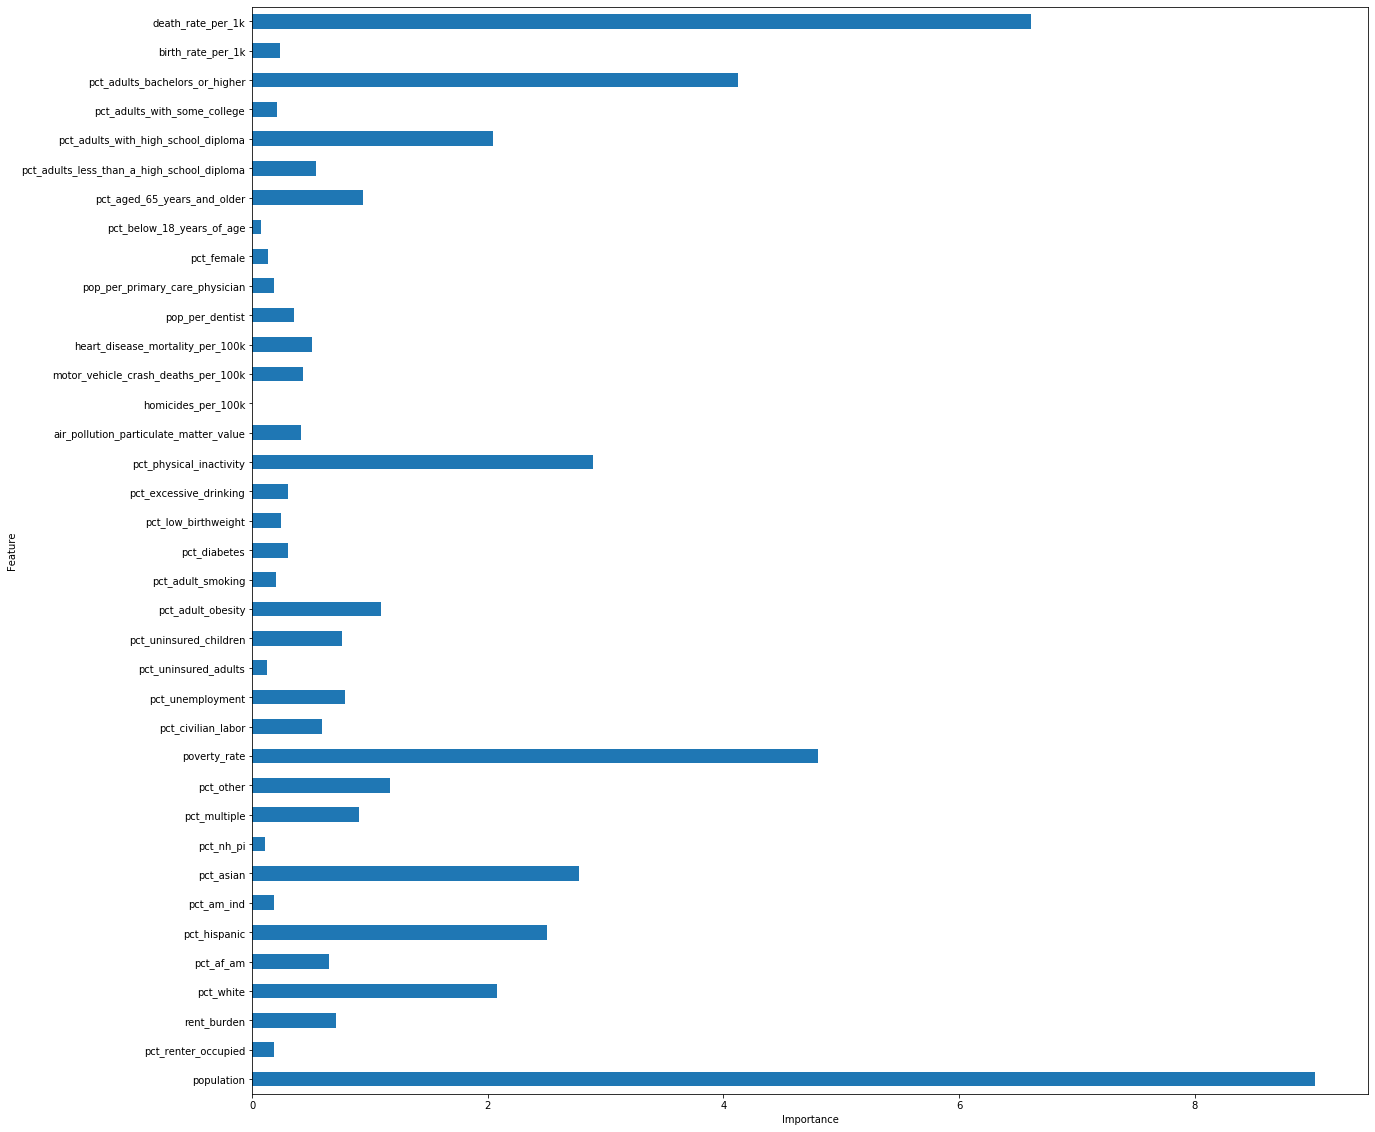

In [71]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

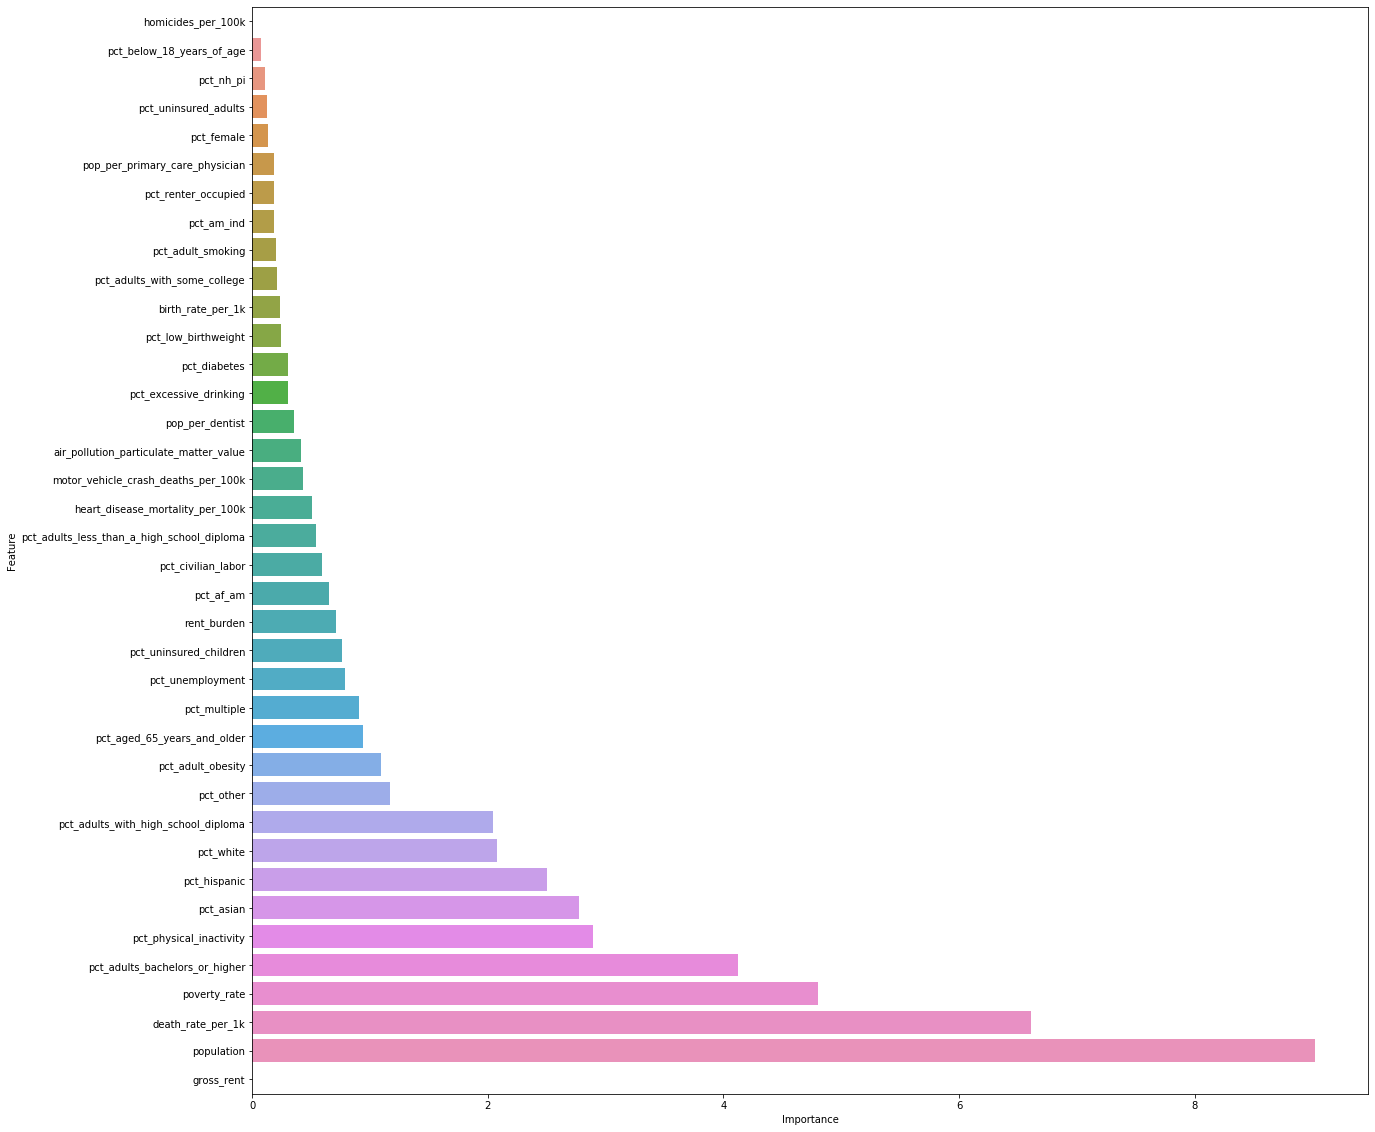

In [72]:
plt.figure(figsize=(20,20))
sns.barplot(x=combined3.LossFunction,y=combined3.Name)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()